In [1]:
######## Installing the required packages ############

# !pip3 install pandas
# !pip3 install mycolorpy
# !pip3 install squarify
# !pip3 install spacy
# !pip3 install pyLDAvis
# !pip install seaborn
# !pip install nltk

In [ ]:
!python -m spacy download en_core_web_sm

In [2]:
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
from mycolorpy import colorlist as mcp
import squarify 
import seaborn as sns

import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words

import nltk
nltk.download('stopwords')

#from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [3]:
#### Loading the data ####
df = pd.read_csv(r'./data/sdgs no privacy.csv')

In [4]:
df.shape

(4304, 41)

In [5]:
df.columns

Index(['Publication ID', 'User ID', 'Name', 'Username', 'Email',
       'User's proprietary ID', 'Primary group descriptor', 'Primary group',
       'Is current staff', 'Publication type', 'SDG label description',
       'Title', 'authors', 'abstract', 'doi', 'issn', 'eissn', 'editors',
       'edition', 'series', 'isbn-10', 'patent-number', 'place-of-publication',
       'name-of-conference', 'location', 'Journal', 'Parent title', 'Volume',
       'Issue', 'Publisher', 'Publisher_URL', 'Name of conference',
       'Begin page', 'End page', 'Publication date', 'Reporting Date 1',
       'Reporting Date 2', 'Canonical journal title', 'Journal data source',
       'Publication Privacy Level', 'Relationship Privacy Level'],
      dtype='object')

In [6]:
len(df['SDG label description'].unique())

17

In [7]:
pub_counts = df.groupby(['SDG label description'])['Publication ID'].count().to_frame().reset_index()

In [8]:
pub_counts.head()

,SDG label description,Publication ID
0,1 No Poverty,66
1,10 Reduced Inequalities,98
2,11 Sustainable Cities and Communities,141
3,12 Responsible Consumption and Production,176
4,13 Climate Action,571


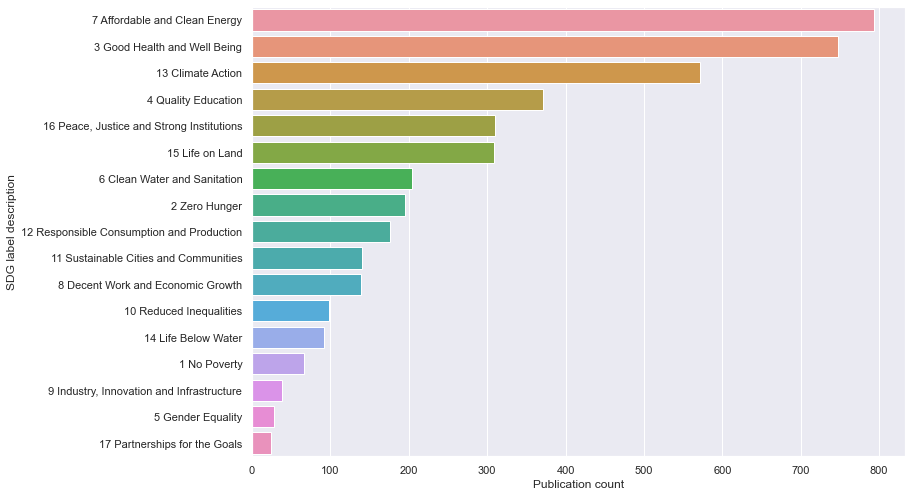

In [9]:
#### Count of Publications for every SDG ####

pub_counts = pub_counts.sort_values('Publication ID',ascending=False)

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(y = pub_counts['SDG label description'], x= pub_counts['Publication ID'])
plt.xlabel("Publication count")
plt.ylabel('SDG label description')
plt.show()

In [10]:
########### LDA Topic Modelling ############

In [11]:
df_topic = df[['Publication ID','Title','abstract','SDG label description']]
df_topic['Title_cleaned'] = df_topic['Title'].str.replace('[{}]'.format(string.punctuation), '').str.lower()
df_topic['Title_cleaned'] = df_topic['Title_cleaned'].str.strip()
df_topic.Title_cleaned = df_topic.Title_cleaned.fillna('')
df_topic['abs_cleaned'] = df_topic['abstract'].str.replace('[{}]'.format(string.punctuation), '').str.lower()
df_topic['abs_cleaned'] = df_topic['abs_cleaned'].str.strip()
df_topic.abs_cleaned = df_topic.abs_cleaned.fillna('')
df_topic['topic_abstract'] = df_topic['Title_cleaned']  + df_topic['abs_cleaned']

C:\Users\ammitra\AppData\Local\Temp\ipykernel_21804\1116575122.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_topic['Title_cleaned'] = df_topic['Title'].str.replace('[{}]'.format(string.punctuation), '').str.lower()
C:\Users\ammitra\AppData\Local\Temp\ipykernel_21804\1116575122.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_topic['Title_cleaned'] = df_topic['Title'].str.replace('[{}]'.format(string.punctuation), '').str.lower()
C:\Users\ammitra\AppData\Local\Temp\ipykernel_21804\1116575122.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [12]:
df_topic.shape

(4304, 7)

In [14]:
df_topic['topic_abstract']

0       dissecting convolutional neural networks for e...
1       the role of appropriate sustainable energy tec...
2       the role of appropriate sustainable energy tec...
3       delivery and student perceptions of drivethrou...
4       loss of power supply probability of standalone...
                              ...                        
4299    isotopic partitioning of evapotranspiration in...
4300    isotopic partitioning of evapotranspiration in...
4301    effects of climate variability and management ...
4302    management and climate variability effects on ...
4303    management and climate variability effects on ...
Name: topic_abstract, Length: 4304, dtype: object

In [15]:
df_topic['SDG label description'].unique()

array(['7 Affordable and Clean Energy', '6 Clean Water and Sanitation',
       '4 Quality Education', '13 Climate Action',
       '3 Good Health and Well Being',
       '16 Peace, Justice and Strong Institutions',
       '11 Sustainable Cities and Communities',
       '12 Responsible Consumption and Production',
       '8 Decent Work and Economic Growth',
       '17 Partnerships for the Goals',
       '9 Industry, Innovation and Infrastructure', '2 Zero Hunger',
       '15 Life on Land', '14 Life Below Water', '1 No Poverty',
       '10 Reduced Inequalities', '5 Gender Equality'], dtype=object)

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2022-04-29 10:49:05.670707: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-29 10:49:05.671138: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [16]:
#### LDA Topic Model Function ###

def identify_topic(Topic,num_topics):

    data = df_topic[df_topic['SDG label description'] == Topic]
    data = data.topic_abstract.values.tolist()
    
    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
    
    data_words = list(sent_to_words(data))
    
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=50)  
    
    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    
    # Define functions for stopwords, bigrams, trigrams and lemmatization
    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    
    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]
    
    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out
    
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)
    
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)
    
    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)
    
    # Create Corpus
    texts = data_lemmatized
    
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
    
    # Print the Keyword in the 10 topics
    #pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus]
    
    return(lda_model,corpus,id2word)


## 7 Affordable and Clean Energy

In [21]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [22]:
lda_model,corpus,id2word = identify_topic(Topic = '7 Affordable and Clean Energy', num_topics = 4)

lda_display = gensimvis.prepare(lda_model, corpus, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

C:\Users\ammitra\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


## 3 Good Health and Well Being

In [23]:
lda_model,corpus,id2word = identify_topic(Topic = '3 Good Health and Well Being', num_topics = 4)

lda_display = gensimvis.prepare(lda_model, corpus, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

C:\Users\ammitra\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


## 13 Climate Action

In [24]:
lda_model,corpus,id2word = identify_topic(Topic = '13 Climate Action', num_topics = 4)

lda_display = gensimvis.prepare(lda_model, corpus, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

C:\Users\ammitra\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


## 4 Quality Education

In [25]:
lda_model,corpus,id2word = identify_topic(Topic = '4 Quality Education', num_topics = 4)

lda_display = gensimvis.prepare(lda_model, corpus, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

C:\Users\ammitra\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


## 16 Peace, Justice and Strong Institutions

In [26]:
lda_model,corpus,id2word = identify_topic(Topic = '16 Peace, Justice and Strong Institutions', num_topics = 3)

lda_display = gensimvis.prepare(lda_model, corpus, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

C:\Users\ammitra\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


## 15 Life on Land

In [40]:
lda_model,corpus,id2word = identify_topic(Topic = '15 Life on Land', num_topics = 3)

lda_display = gensimvis.prepare(lda_model, corpus, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

C:\Users\ammitra\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


## 6 Clean Water and Sanitation

In [41]:
lda_model,corpus,id2word = identify_topic(Topic = '6 Clean Water and Sanitation', num_topics = 3)
pyLDAvis.display(lda_display)

## 2 Zero Hunger

In [33]:
lda_model,corpus,id2word = identify_topic(Topic = '2 Zero Hunger', num_topics = 4)

lda_display = gensimvis.prepare(lda_model, corpus, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

C:\Users\ammitra\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


## 12 Responsible Consumption and Production

In [32]:
lda_model,corpus,id2word = identify_topic(Topic = '12 Responsible Consumption and Production', num_topics = 3)

lda_display = gensimvis.prepare(lda_model, corpus, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

C:\Users\ammitra\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


## 11 Sustainable Cities and Communities

In [36]:
lda_model,corpus,id2word = identify_topic(Topic = '11 Sustainable Cities and Communities', num_topics = 3)

lda_display = gensimvis.prepare(lda_model, corpus, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

C:\Users\ammitra\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
